# Test Tensorflow-federated (TFF) library

## Test #2 : model with local personnalization

In [1]:
import os
import functools
import collections
import nest_asyncio
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff

from utils import plot, plot_multiple

tf.config.set_visible_devices([tf.config.list_physical_devices('GPU')[0]], 'GPU')

nest_asyncio.apply()

print('Tensorflow version : {}'.format(tf.__version__))
print('Tensorflow-federated version : {}'.format(tff.__version__))
print('# GPUs : {}'.format(len(tf.config.list_logical_devices('GPU'))))

tff.federated_computation(lambda: 'Hello, World!')()

2022-11-15 08:56:49.988145: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 08:56:50.088220: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-15 08:56:50.112071: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/etinfo/users2/qlanglois/.local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is requir

Tensorflow version : 2.10.0
Tensorflow-federated version : 0.39.0
# GPUs : 1


2022-11-15 08:57:05.507958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 08:57:05.884157: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14783 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:17:00.0, compute capability: 7.5


b'Hello, World!'

In [2]:
emnist_train, emnist_valid = tff.simulation.datasets.emnist.load_data()
print('Dataset length :\n  Train length : {}\n  Valid length : {}'.format(
    len(emnist_train.client_ids), len(emnist_valid.client_ids)
))
print('Data signature : {}'.format(emnist_train.element_type_structure))

Dataset length :
  Train length : 3383
  Valid length : 3383
Data signature : OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)), ('pixels', TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])


In [3]:
def preprocess(dataset, epochs = 50, batch_size = 32, shuffle_size = 1024, prefetch_size = 16):
    def batch_format_fn(data):
        return collections.OrderedDict(
            x = tf.reshape(data['pixels'], [-1, 28 * 28]),
            y = tf.reshape(data['label'], [-1, 1])
        )
    
    return dataset.repeat(epochs).shuffle(shuffle_size, seed = 1).batch(batch_size).map(batch_format_fn).prefetch(prefetch_size)

def make_federated_data(client_data, ids = None, n = None):
    if ids is None: ids = client_data.client_ids[:n]
    return [
        preprocess(client_data.create_tf_dataset_for_client(x)) for x in ids
    ]

train_fed_data = make_federated_data(emnist_train, n = 500)
valid_fed_data = make_federated_data(emnist_valid, n = 100)

print('# datasets : train {} - valid {}'.format(len(train_fed_data), len(valid_fed_data)))

# datasets : train 500 - valid 100


## Model initialization

In [9]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape = (28 * 28, )),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
    ])
    
    global_layers = model.layers[:-1]
    local_layers  = model.layers[-1:]
    
    input_spec    = collections.OrderedDict(
        x = tf.TensorSpec(shape = (None, 28 * 28), dtype = tf.float32),
        y = tf.TensorSpec(shape = (None, 1), dtype = tf.int32)
    )
    return tff.learning.reconstruction.from_keras_model(
        model,
        global_layers = global_layers,
        local_layers  = local_layers,
        input_spec    = input_spec
    )

model_fn   = functools.partial(build_model)
loss_fn    = lambda: tf.keras.losses.SparseCategoricalCrossentropy()
metrics_fn = lambda: [tf.keras.metrics.SparseCategoricalAccuracy()]

## Training and evaluation

### Training initialization

In [10]:
training_process = tff.learning.reconstruction.build_training_process(
    model_fn   = model_fn,
    loss_fn    = loss_fn,
    metrics_fn = metrics_fn,
    server_optimizer_fn = lambda: tf.keras.optimizers.SGD(0.5),
    client_optimizer_fn = lambda: tf.keras.optimizers.SGD(0.1),
    reconstruction_optimizer_fn = lambda: tf.keras.optimizers.SGD(0.01)
)

evaluation_process = tff.learning.reconstruction.build_federated_evaluation(
    model_fn   = model_fn,
    loss_fn    = loss_fn,
    metrics_fn = metrics_fn,
    reconstruction_optimizer_fn = functools.partial(
        tf.keras.optimizers.SGD, 0.01
    )
)
print(training_process.initialize.type_signature.formatted_representation())

( -> <
  model=<
    trainable=<
      float32[784,128],
      float32[128]
    >,
    non_trainable=<>
  >,
  optimizer_state=<
    int64
  >,
  delta_aggregate_state=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  model_broadcast_state=<>
>@SERVER)


In [11]:
state = training_process.initialize()
print(state)
print(state.model)

ServerState(model=ModelWeights(trainable=[array([[-0.01733214,  0.02006286, -0.00688466, ..., -0.04876081,
         0.05514441,  0.03724729],
       [ 0.03035156,  0.02444299, -0.0367365 , ..., -0.07960955,
         0.03855696,  0.00602961],
       [-0.07142485,  0.04485162,  0.02070482, ...,  0.00077359,
        -0.00656562,  0.02826265],
       ...,
       [ 0.03630129,  0.07082141, -0.04481804, ...,  0.05781945,
         0.07570203, -0.05049385],
       [ 0.01484481, -0.01315447, -0.02889612, ...,  0.07479808,
         0.05986726,  0.0412863 ],
       [ 0.06592431,  0.07512348,  0.03300899, ...,  0.04836562,
         0.0628748 ,  0.05032822]], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.

In [12]:
valid_metrics = evaluation_process(state.model, valid_fed_data)
print('Initial metrics : {}'.format(valid_metrics))

2022-11-15 08:59:54.724625: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 08:59:54.724659: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 08:59:54.725569: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 08:59:54.725598: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 08:59:54.761450: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 08:59:54.761520: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 08:59:54.807591: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 08:59:54.807618: I tensorflow/

Initial metrics : OrderedDict([('broadcast', ()), ('eval', OrderedDict([('loss', 2.1376026), ('sparse_categorical_accuracy', 0.23597503)]))])


In [14]:
train_samples = np.random.choice(train_fed_data, size = 50, replace = False).tolist()
state, metrics = training_process.next(state, train_samples)
print('Round 1 metrics : {}'.format(metrics))

2022-11-15 09:03:25.843396: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:03:25.843424: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:03:26.054396: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:03:26.054426: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:03:26.059128: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:03:26.059157: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:03:26.068194: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:03:26.068226: I tensorflow/

Round 1 metrics : OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.1012654), ('loss', 2.549729)]))])


### Training loop

2022-11-15 09:05:16.091872: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:16.091896: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:16.091920: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:16.091984: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:16.092000: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:16.092018: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:16.092680: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:16.092741: I tensorflow/

Round 0 metrics : OrderedDict([('sparse_categorical_accuracy', 0.10316714), ('loss', 2.5272305)])


2022-11-15 09:05:22.107625: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:22.107650: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:22.108524: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:22.108596: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:22.108730: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:22.108745: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:22.108758: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:22.108771: I tensorflow/

Round 1 metrics : OrderedDict([('sparse_categorical_accuracy', 0.116946034), ('loss', 2.29586)])


2022-11-15 09:05:28.063863: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:28.063891: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:28.064256: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:28.064268: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:28.064285: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:28.064340: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:28.064791: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:28.064810: I tensorflow/

Round 2 metrics : OrderedDict([('sparse_categorical_accuracy', 0.12314938), ('loss', 2.29806)])


2022-11-15 09:05:33.881865: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:33.881890: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:33.882018: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:33.882116: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:33.882787: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:33.882813: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:33.882848: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:33.882884: I tensorflow/

Round 3 metrics : OrderedDict([('sparse_categorical_accuracy', 0.12335473), ('loss', 2.298952)])


2022-11-15 09:05:39.965882: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:39.965909: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:39.965946: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:39.966029: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:39.966197: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:39.966225: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:39.966519: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:39.966564: I tensorflow/

Round 4 metrics : OrderedDict([('sparse_categorical_accuracy', 0.12154945), ('loss', 2.2997987)])


2022-11-15 09:05:45.902395: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:45.902422: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:45.902477: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:45.902509: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:45.902930: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:45.902975: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:45.903349: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:45.903394: I tensorflow/

Round 5 metrics : OrderedDict([('sparse_categorical_accuracy', 0.12173594), ('loss', 2.2998548)])


2022-11-15 09:05:52.749679: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:52.749707: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:52.749990: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:52.750007: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:52.750251: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:52.750290: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:52.750332: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:52.750374: I tensorflow/

Round 6 metrics : OrderedDict([('sparse_categorical_accuracy', 0.122601226), ('loss', 2.2994714)])


2022-11-15 09:05:58.673412: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:58.673440: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:58.674073: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:58.674537: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:58.674551: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:58.674571: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:58.674631: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:05:58.674693: I tensorflow/

Round 7 metrics : OrderedDict([('sparse_categorical_accuracy', 0.12206554), ('loss', 2.2997694)])


2022-11-15 09:06:04.797268: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:04.797338: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:04.797508: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:04.797540: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:04.797612: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:04.797628: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:04.798312: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:04.798348: I tensorflow/

Round 8 metrics : OrderedDict([('sparse_categorical_accuracy', 0.12395161), ('loss', 2.2987034)])


2022-11-15 09:06:10.717967: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:10.717994: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:10.718824: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:10.718843: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:10.718862: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:10.718926: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:10.719043: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:10.719057: I tensorflow/

Round 9 metrics : OrderedDict([('sparse_categorical_accuracy', 0.122689426), ('loss', 2.2975817)])


2022-11-15 09:06:16.563344: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:16.563374: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:16.563393: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:16.563404: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:16.563421: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:16.563433: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:16.563804: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:16.563839: I tensorflow/

Round 10 metrics : OrderedDict([('sparse_categorical_accuracy', 0.12235776), ('loss', 2.2966864)])


2022-11-15 09:06:22.864341: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:22.864369: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:22.864540: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:22.864595: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:22.864612: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:22.864628: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:22.865124: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:22.865528: I tensorflow/

Round 11 metrics : OrderedDict([('sparse_categorical_accuracy', 0.1266248), ('loss', 2.2946763)])


2022-11-15 09:06:28.949558: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:28.949584: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:28.949603: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:28.949619: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:28.950318: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:28.950359: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:28.950811: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:28.950850: I tensorflow/

Round 12 metrics : OrderedDict([('sparse_categorical_accuracy', 0.119345725), ('loss', 2.2926767)])


2022-11-15 09:06:35.180188: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:35.180238: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:35.180315: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:35.180358: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:35.180579: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:35.180593: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:35.180744: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:35.180835: I tensorflow/

Round 13 metrics : OrderedDict([('sparse_categorical_accuracy', 0.127143), ('loss', 2.2889528)])


2022-11-15 09:06:41.310701: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:41.310774: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:41.310792: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:41.310947: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:41.311011: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:41.311026: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:41.311229: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:41.311247: I tensorflow/

Round 14 metrics : OrderedDict([('sparse_categorical_accuracy', 0.13102189), ('loss', 2.2821624)])


2022-11-15 09:06:47.177685: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:47.177711: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:47.178143: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:47.178160: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:47.178310: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:47.178364: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:47.178464: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:47.178520: I tensorflow/

Round 15 metrics : OrderedDict([('sparse_categorical_accuracy', 0.13355769), ('loss', 2.2749658)])


2022-11-15 09:06:53.087327: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:53.087354: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:53.088178: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:53.088198: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:53.088225: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:53.088754: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:53.088802: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:53.089123: I tensorflow/

Round 16 metrics : OrderedDict([('sparse_categorical_accuracy', 0.13649805), ('loss', 2.272609)])


2022-11-15 09:06:59.393840: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:59.393866: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:59.394159: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:59.394182: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:59.394435: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:59.394558: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:59.394572: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:06:59.394608: I tensorflow/

Round 17 metrics : OrderedDict([('sparse_categorical_accuracy', 0.14070503), ('loss', 2.260778)])


2022-11-15 09:07:05.585630: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:05.585663: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:05.586241: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:05.586259: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:05.586276: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:05.586288: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:05.586306: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:05.586324: I tensorflow/

Round 18 metrics : OrderedDict([('sparse_categorical_accuracy', 0.14130576), ('loss', 2.249153)])


2022-11-15 09:07:11.819634: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:11.819659: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:11.819871: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:11.819884: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:11.820180: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:11.820244: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:11.820449: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:11.820463: I tensorflow/

Round 19 metrics : OrderedDict([('sparse_categorical_accuracy', 0.1484784), ('loss', 2.242831)])


2022-11-15 09:07:17.810295: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:17.810323: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:17.810699: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:17.810727: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:17.810744: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:17.810839: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:17.810893: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:17.811026: I tensorflow/

Round 20 metrics : OrderedDict([('sparse_categorical_accuracy', 0.15621813), ('loss', 2.230214)])


2022-11-15 09:07:23.870459: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:23.870484: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:23.870523: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:23.870579: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:23.870939: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:23.870957: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:23.872030: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:23.872082: I tensorflow/

Round 21 metrics : OrderedDict([('sparse_categorical_accuracy', 0.16008374), ('loss', 2.2191255)])


2022-11-15 09:07:29.794451: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:29.794478: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:29.794491: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:29.794512: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:29.794528: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:29.794581: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:29.794849: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:29.794864: I tensorflow/

Round 22 metrics : OrderedDict([('sparse_categorical_accuracy', 0.1600932), ('loss', 2.2114904)])


2022-11-15 09:07:35.846454: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:35.846499: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:35.846550: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:35.846573: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:35.847528: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:35.847628: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:35.847765: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:35.847785: I tensorflow/

Round 23 metrics : OrderedDict([('sparse_categorical_accuracy', 0.1672522), ('loss', 2.1996307)])


2022-11-15 09:07:42.210178: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:42.210202: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:42.210347: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:42.210388: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:42.210403: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:42.210454: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:42.210871: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:42.210908: I tensorflow/

Round 24 metrics : OrderedDict([('sparse_categorical_accuracy', 0.1720654), ('loss', 2.1904125)])


2022-11-15 09:07:48.454454: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:48.454485: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:48.454603: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:48.454619: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:48.455162: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:48.455175: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:48.455194: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2022-11-15 09:07:48.455215: I tensorflow/

Final evaluation metrics : OrderedDict([('loss', 2.2396243), ('sparse_categorical_accuracy', 0.15657885)])


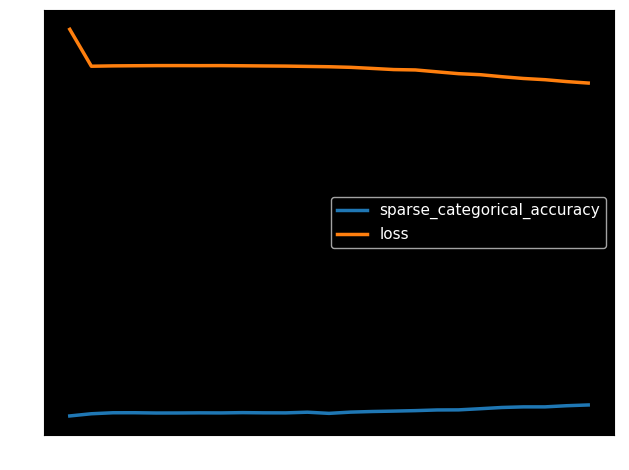

In [17]:
from loggers import set_level
set_level('warning', 'tensorflow')

epochs = 25

all_metrics = {}

state = training_process.initialize()

for i in range(epochs):
    train_samples = np.random.choice(train_fed_data, size = 50, replace = False).tolist()
    state, metrics = training_process.next(state, train_samples)
    print('Round {} metrics : {}'.format(i, metrics['train']))
    for k, v in metrics['train'].items():
        all_metrics.setdefault(k, []).append(v)

valid_metrics = evaluation_process(state.model, valid_fed_data)
print('Final evaluation metrics : {}'.format(valid_metrics['eval']))

_ = plot(all_metrics)

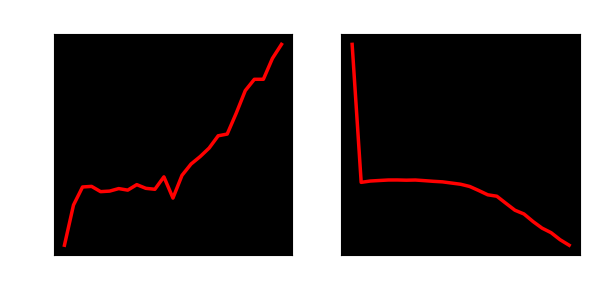

In [18]:
plot_multiple(** all_metrics, use_subplots = True)